# ALOS Data Analysis <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">


* **Products used:** 
[alos_palsar_mosaic](https://explorer.dev.digitalearth.africa/products/alos_palsar_mosaic)

## Background

The ALOS/ALOS2 PALSAR annual mosaic is a global 25 m resolution dataset that combines data from many images captured by JAXA’s PALSAR and PALSAR-2 sensors on ALOS-1 and ALOS-2 satellites respectively. This product contains radar measurement in L-band and in HH and HV polarizations. It has a spatial resolution of 25m and is available annually for 2007 to 2010 (ALOS/PALSAR) and 2015 to 2018 (ALOS-2/PALSAR-2).
These mosaic data is part of a global [dataset](https://www.eorc.jaxa.jp/ALOS/en/palsar_fnf/fnf_index.htm) provided by the Japan Aerospace Exploration Agency (JAXA) Earth Observation Research Center.

DE Africa's ALOS/ALOS-2 PALSAR/PALSAR-2 mosaic is a Normalized Radar Backscatter data, for which Radiometric Terrain Correction (RTC) has been applied so data acquired with different imaging geometries over the same region.The relevant coverage and metadata of this dataset can be viewed on [DE Africa Metadata Explorer](https://explorer.dev.digitalearth.africa/products/alos_palsar_mosaic/extents) and forms a single, cohesive Analysis Ready Data (ARD) package, which allows you to analyse radar backscatter data as-is without the need to apply additional corrections.

**Important details:**

* SAR annual mosaic product specifications
    * Number of bands: `5` (`0` is `no-data`)
    * To achieve backscatter in decibel unit, convert backscatter values in Digital Number (DN) using $ 10 * log10(DN^2) - 83.0 $

* Mask specification includes `0` for `no-data`, `50` for water, `100` for lay_over, `150` for shadowing and `255` for land
* Native pixel alignment is `centre`
* Date-range: 2007 to 2018
* Spatial resolution: 25 x 25 m

For a detailed description of DE Africa's ALOS/ALOS2 PALSAR archive, see the DE Africa's [ALOS/ALOS2 technical specifications documentation]() **placeholder link - to update**

## Description

In this notebook we will load **ALOS PALSAR** data using [dc.load()](../Beginners_guide/03_Loading_data.ipynb) to return a time series of satellite images from a single sensor. The returned `xarray.Dataset` will contain analysis ready images with the invalid pixels masked out.

Topics covered include:
1. Inspecting the ALOS PALSAR products and measurements available in the datacube
2. Using the native `dc.load()` function to load in ALOS PALSAR data 
3. Applying a single band analysis to different polarisation 

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
%matplotlib inline
import datacube
import sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from xarray.ufuncs import isfinite

sys.path.append('../../Scripts')
from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb, display_map

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app="ALOS_Viewer")

## Available products and measurements

### List products

We can use datacube's `list_products` functionality to inspect DE Africa's Landsat products that are available in the datacube. The table below shows the product names that we will use to load the data, a brief description of the data, and the satellite instrument that acquired the data.

> We can search for Landsat Collection 2, Level 2 data by using the search term `c2l2`. `c2l2` stands for **C**ollection **2** **L**evel **2**. The datacube is case-sensitive so this must be typed in lower case.

In [3]:
product = "alos_palsar_mosaic"

### List measurements

We can further inspect the data available for each Landsat product using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data.

In [4]:
measurements = dc.list_measurements()
measurements.loc[product]

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
hh,hh,int16,1,0,[hh],NaN
hv,hv,int16,1,0,[hv],NaN
date,date,int16,1,0,[date],NaN
linci,linci,uint8,1,0,"[local incidence angle, linci, incidence]",NaN
mask,mask,uint8,1,0,[mask],"{'category': {'bits': [0, 1, 2, 3, 4, 5, 6, 7]..."


## Load ALOS PALSAR using `dc.load()`

Now that we know what products and measurements are available for the products, we can load data from the datacube using `dc.load`.

In the example below, we will load data from Landsat 8 from Cape Town for South Africa in January 2018. We will load data from three spectral satellite bands, as well as cloud masking data (`'quality_l2_aerosol'`). By specifying `output_crs='EPSG:6933'` and `resolution=(-30, 30)`, we request that datacube reproject our data to the African Albers coordinate reference system (CRS), with 30 x 30 m pixels. Finally, `group_by='solar_day'` ensures that overlapping images taken within seconds of each other as the satellite passes over are combined into a single time step in the data.

> Note: For a more general discussion of how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.


In [5]:
# Load the data
lat = (6.1064, 5.7854)
lon = (0.4607, 1.0094)
time_extents = ('2007-07-02', '2018-07-02')

ds = dc.load(product="alos_palsar_mosaic",
                 x=lon,
                 y=lat,
                 time=time_extents)
print(ds)

<xarray.Dataset>
Dimensions:      (latitude: 1445, longitude: 2470, time: 8)
Coordinates:
  * time         (time) datetime64[ns] 2007-07-02T12:00:00 ... 2018-07-02T12:...
  * latitude     (latitude) float64 6.106 6.106 6.106 ... 5.786 5.786 5.785
  * longitude    (longitude) float64 0.4608 0.461 0.4612 ... 1.009 1.009 1.009
    spatial_ref  int32 4326
Data variables:
    hh           (time, latitude, longitude) int16 2448 2486 2042 ... 1632 2160
    hv           (time, latitude, longitude) int16 843 1158 1186 ... 333 302 360
    date         (time, latitude, longitude) int16 588 588 588 ... 1522 1522
    linci        (time, latitude, longitude) uint8 36 36 39 43 ... 35 35 35 35
    mask         (time, latitude, longitude) uint8 255 255 255 255 ... 50 50 50
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref


### Visualise the selected area 

In [6]:
display_map(x=lon,y=lat)

In [7]:
#creation of a new band (HH/HV = hhhv) for RGB display 
ds['hhhv'] = ds.hh / ds.hv
ds

<xarray.Dataset>
Dimensions:      (latitude: 1445, longitude: 2470, time: 8)
Coordinates:
  * time         (time) datetime64[ns] 2007-07-02T12:00:00 ... 2018-07-02T12:...
  * latitude     (latitude) float64 6.106 6.106 6.106 ... 5.786 5.786 5.785
  * longitude    (longitude) float64 0.4608 0.461 0.4612 ... 1.009 1.009 1.009
    spatial_ref  int32 4326
Data variables:
    hh           (time, latitude, longitude) int16 2448 2486 2042 ... 1632 2160
    hv           (time, latitude, longitude) int16 843 1158 1186 ... 333 302 360
    date         (time, latitude, longitude) int16 588 588 588 ... 1522 1522
    linci        (time, latitude, longitude) uint8 36 36 39 43 ... 35 35 35 35
    mask         (time, latitude, longitude) uint8 255 255 255 255 ... 50 50 50
    hhhv         (time, latitude, longitude) float64 2.904 2.147 ... 5.404 6.0
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

## Single Data Analysis 

In [8]:
#choose a single acquisition by its index (listed above)
acq_ind_to_show = 6

In [9]:
hist_ds = ds.isel(time=acq_ind_to_show)[['hh','hv']]
hist_ds = hist_ds.where(isfinite(hist_ds))

min_per_data_var = hist_ds.quantile(0.001).to_array().values
min_val = min_per_data_var[np.isfinite(min_per_data_var)].min()

max_per_data_var = hist_ds.quantile(0.999).to_array().values
max_val = max_per_data_var[np.isfinite(max_per_data_var)].max()

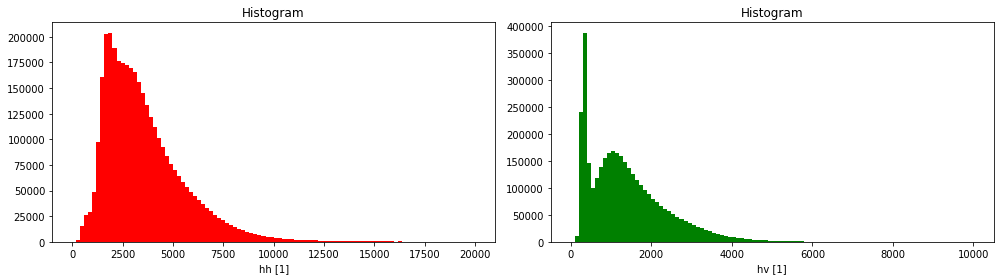

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))

ds.isel(time=acq_ind_to_show).hh.plot.hist(ax=ax[0], bins=100, 
                                                range=(0,20000), facecolor='red')
ds.isel(time=acq_ind_to_show).hv.plot.hist(ax=ax[1], bins=100, 
                                                range=(0,10000), facecolor='green')

plt.tight_layout()
plt.show()

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [11]:
print(datacube.__version__)

1.8.4.dev52+g07bc51a5


**Last Tested:**

In [12]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-04-16'